Using device: cuda
Null values before cleaning: 6
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2014-09-18  456.859985  456.859985  413.104004  424.440002  424.440002   
2014-09-19  424.102997  427.834991  384.532013  394.795990  394.795990   
2014-09-20  394.673004  423.295990  389.882996  408.903992  408.903992   
2014-09-21  408.084991  412.425995  393.181000  398.821014  398.821014   
2014-09-22  399.100006  406.915985  397.130005  402.152008  402.152008   

                Volume  
Date                    
2014-09-18  34483200.0  
2014-09-19  37919700.0  
2014-09-20  36863600.0  
2014-09-21  26580100.0  
2014-09-22  24127600.0  
               Open          High           Low         Close     Adj Close  \
count   3412.000000   3412.000000   3412.000000   3412.000000   3412.000000   
mean   14747.360368  15091.809098  14376.126435  14758.111980  14758.111980   
std    16293.633702

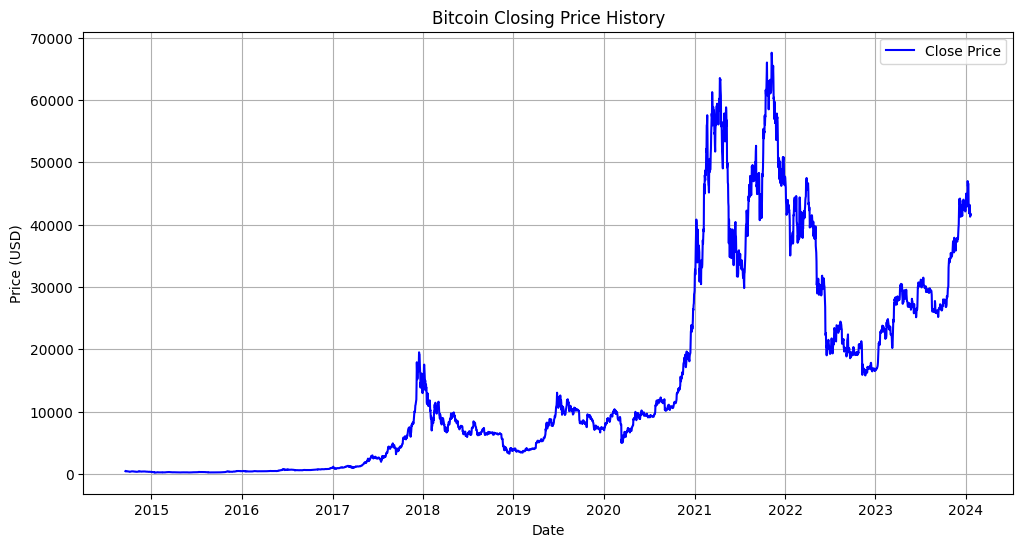

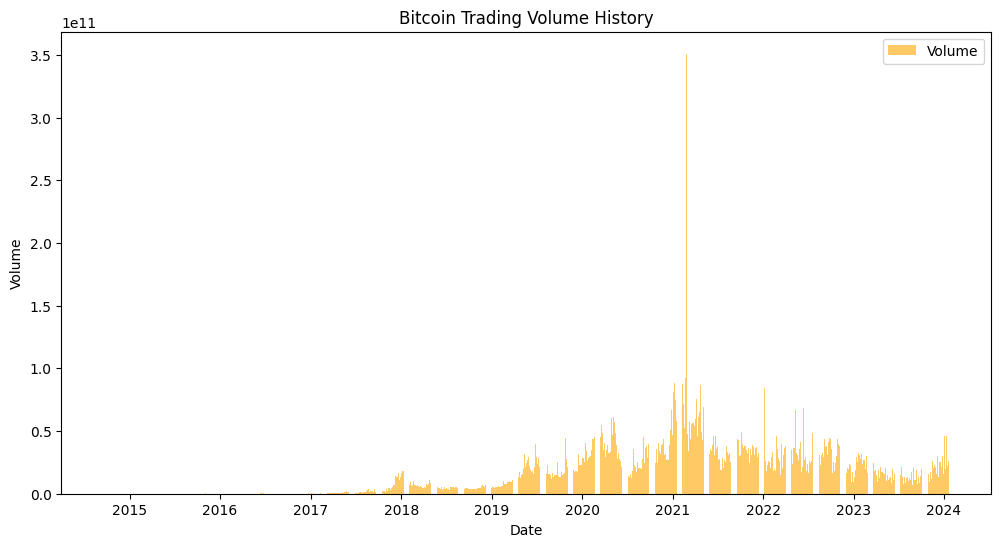

In [12]:
# 1. Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load the Dataset
df = pd.read_csv('/kaggle/input/bitcoin-price-dataset-2014-2025/BTC-USD (2014-2024).csv')

# Check for null values
print(f"Null values before cleaning: {df.isnull().sum().sum()}")

# Drop any rows with missing values
df.dropna(inplace=True)

# Convert Date column to datetime format for better plotting
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)
df.set_index('Date', inplace=True)


# Exploratory Data Analysis 
print(df.head())
print(df.describe())

# Graph 1: Closing Price over time
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Close'], label='Close Price', color='blue')
plt.title('Bitcoin Closing Price History')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.grid(True)
plt.show()

# Graph 2: Volume over time
plt.figure(figsize=(12, 6))
plt.bar(df.index, df['Volume'], label='Volume', color='orange', alpha=0.6)
plt.title('Bitcoin Trading Volume History')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.legend()
plt.show()

In [13]:
# Feature Selection
# We will use 'Close' price for prediction.
data = df[['Close']].values

# Normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Check for infinite numbers in scaled data
if np.isnan(scaled_data).any() or np.isinf(scaled_data).any():
    print("Error: Dataset contains NaNs or Infs after scaling!")
    # Replace weird values with 0 or the mean
    scaled_data = np.nan_to_num(scaled_data)

# Create Sequences 
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:(i + seq_length)] # Input: Days 0 to 59
        y = data[i + seq_length]     # Target: Day 60
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

SEQ_LENGTH = 60  # Look back 60 days
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Train/Test Split
train_size = int(len(y) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to PyTorch Tensors
X_train = torch.from_numpy(X_train).float().to(device)
y_train = torch.from_numpy(y_train).float().to(device)
X_test = torch.from_numpy(X_test).float().to(device)
y_test = torch.from_numpy(y_test).float().to(device)

print(f"Training Shape: {X_train.shape}")
print(f"Testing Shape: {X_test.shape}")

Training Shape: torch.Size([2681, 60, 1])
Testing Shape: torch.Size([671, 60, 1])


In [14]:
class BitcoinLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, num_layers=2, output_size=1):
        super(BitcoinLSTM, self).__init__()
        
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Defining LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Defining the Output layer 
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state (h0) and cell state (c0) with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))
        
        # Decoding the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

# Instantiating the model
model = BitcoinLSTM().to(device)
print(model)

BitcoinLSTM(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


Starting Training...
Epoch [10/100], Train Loss: 0.05659, Test Loss: 0.05098
Epoch [20/100], Train Loss: 0.05014, Test Loss: 0.04932
Epoch [30/100], Train Loss: 0.03140, Test Loss: 0.02526
Epoch [40/100], Train Loss: 0.00656, Test Loss: 0.02549
Epoch [50/100], Train Loss: 0.00204, Test Loss: 0.00296
Epoch [60/100], Train Loss: 0.00116, Test Loss: 0.00154
Epoch [70/100], Train Loss: 0.00097, Test Loss: 0.00096
Epoch [80/100], Train Loss: 0.00085, Test Loss: 0.00081
Epoch [90/100], Train Loss: 0.00076, Test Loss: 0.00094
Epoch [100/100], Train Loss: 0.00072, Test Loss: 0.00092


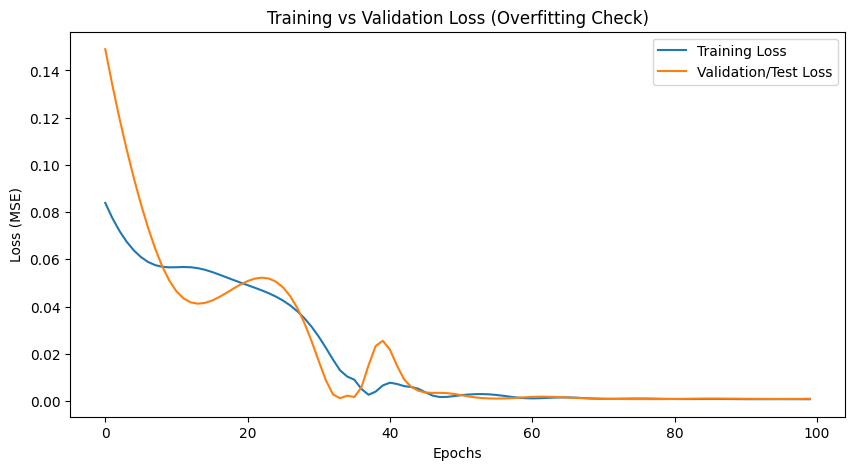

In [15]:
# Hyperparameters
num_epochs = 100
learning_rate = 0.001

# Loss Function: Mean Squared Error 
criterion = nn.MSELoss()
# Optimizer: Adam 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
test_losses = []

print("Starting Training...")

for epoch in range(num_epochs):
    model.train() 
    
    # Forward Pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    # Backward Pass and Optimization
    optimizer.zero_grad() 
    loss.backward()       

    # Clip gradients to prevent explosion 
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
    optimizer.step()      
    
    # Validation 
    model.eval()
    with torch.no_grad(): 
        test_preds = model(X_test)
        test_loss = criterion(test_preds, y_test)
    
    train_losses.append(loss.item())
    test_losses.append(test_loss.item())
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.5f}, Test Loss: {test_loss.item():.5f}')

# Graph: Loss Curve 
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation/Test Loss')
plt.title('Training vs Validation Loss (Overfitting Check)')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

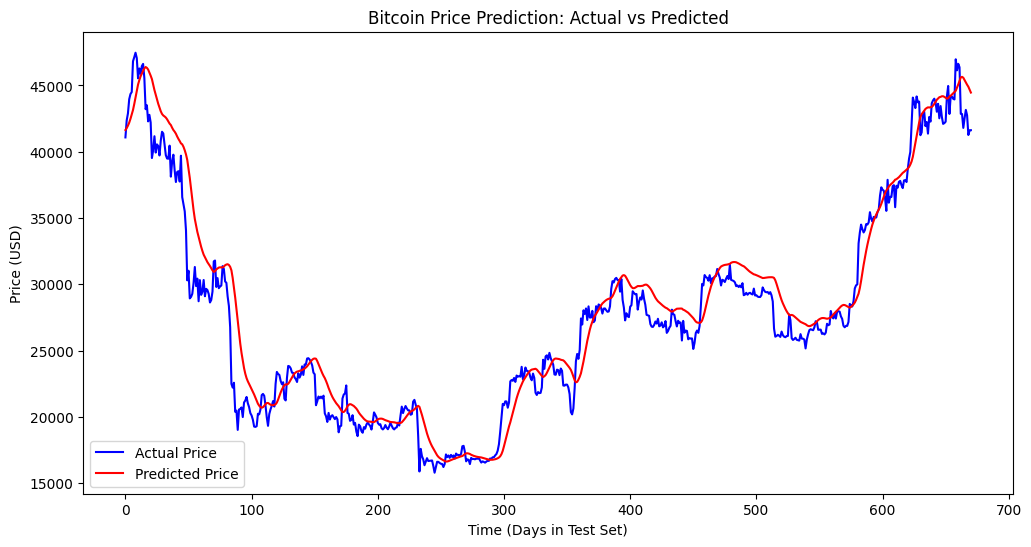

In [16]:
# Predictions on Test Data
model.eval()
with torch.no_grad():
    predicted_scaled = model(X_test).cpu().numpy()

# Inverse transform to get actual prices
predicted_prices = scaler.inverse_transform(predicted_scaled)
actual_prices = scaler.inverse_transform(y_test.cpu().numpy())

# Graph: Actual vs Predicted
plt.figure(figsize=(12, 6))
plt.plot(actual_prices, label='Actual Price', color='blue')
plt.plot(predicted_prices, label='Predicted Price', color='red')
plt.title('Bitcoin Price Prediction: Actual vs Predicted')
plt.xlabel('Time (Days in Test Set)')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

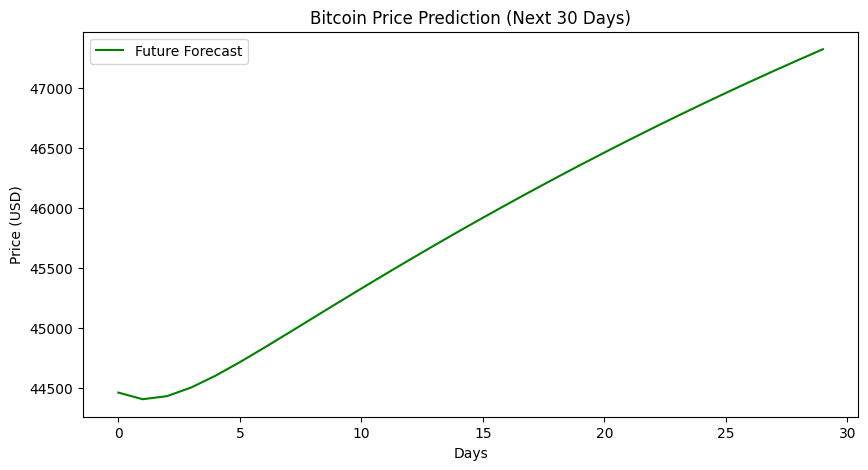

In [17]:
# Predicting next 30 days 
future_days = 30 
last_sequence = X_test[-1].unsqueeze(0)
future_predictions = []

model.eval()
current_seq = last_sequence

for i in range(future_days):
    with torch.no_grad():
        pred = model(current_seq)
        
        # if pred is NaN, stop
        if torch.isnan(pred).item():
            print(f"Stopping early at day {i} due to NaN prediction")
            break
            
        future_predictions.append(pred.item())
        
        # Reshape and update sequence
        new_pred_reshaped = pred.unsqueeze(1) 
        current_seq = torch.cat((current_seq[:, 1:, :], new_pred_reshaped), dim=1)

if future_predictions:
    future_prices = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    
    plt.figure(figsize=(10, 5))
    plt.plot(future_prices, label='Future Forecast', color='green')
    plt.title(f'Bitcoin Price Prediction (Next {future_days} Days)')
    plt.xlabel('Days')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.show()
else:
    print("No predictions generated.")

In [18]:
def predict_custom_price(past_60_days_prices):
    """
    Input: List of 60 float values representing past 60 days closing prices.
    Output: Predicted price for the next day.
    """
    if len(past_60_days_prices) != 60:
        return "Error: Please provide exactly 60 days of prices."
    
    # Preprocess
    input_array = np.array(past_60_days_prices).reshape(-1, 1)
    scaled_input = scaler.transform(input_array)
    
    # Convert to Tensor
    input_tensor = torch.from_numpy(scaled_input).float().unsqueeze(0).to(device)
    
    # Predict
    model.eval()
    with torch.no_grad():
        prediction = model(input_tensor)
    
    # Inverse transform
    predicted_price = scaler.inverse_transform(prediction.cpu().numpy())
    return predicted_price[0][0]

# Example Usage:
dummy_input = df['Close'].tail(60).tolist()
result = predict_custom_price(dummy_input)
print(f"Predicted price based on custom input: ${result:.2f}")

Predicted price based on custom input: $44250.74
